In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

T=4 ##num_steps
INF=10000
NOISE=100
ci=0.05/3
lambdas=np.array([1,5,10])
I=len(lambdas)
n_values=np.linspace(5000,INF,T,dtype=np.int)
Ni_values=(ci)*n_values


## Séparation exacte du spectre
- Setting $N_i=100, n=5000$, i.e. $c=0.06$, we can better observe the separation of the spectrum in two continuous bulks  
We can verify the exact separation and the "no eigenvalue outside de support" theorem sing Gaussian and Uniform distributions



100 5000


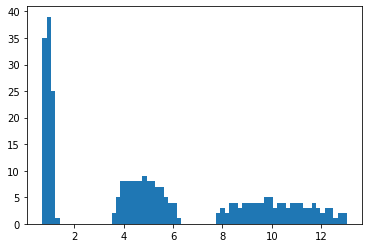

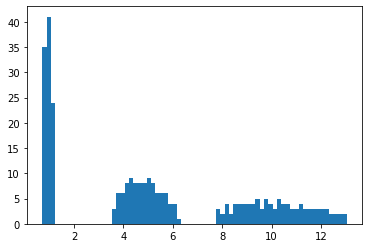

In [102]:
Ni,n=100,5000
#for Ni,n in zip(Ni_values,n_values):
Ni=max(int(Ni),1)
N=Ni*I
print(Ni,n)
l=lambdas[None,:].repeat(Ni,1).reshape(-1)
R=np.diag(l)

##gaussian (finite curtosis) distribution

def random_spectrum(X):
    Sigma=1/n*X.T.conjugate()@R@X

    w,v=np.linalg.eigh(Sigma,)
    whist=w[w>1e-6]
    plt.hist(whist,bins=int(np.sqrt(n)))
    plt.show()
    return w
X=(np.random.rand(N,n)+1j*np.random.rand(N,n)-0.5-0.5j)*np.sqrt(6)
wunif=random_spectrum(X)
X=(np.random.randn(N,n)+1j*np.random.randn(N,n))/np.sqrt(2)
wgauss=random_spectrum(X)
#np.random.rand(N,n)

- A t-student with $\nu=3$ degrees of freedom does not have a finite 4th moment so the exact separation of the support doesn't occur

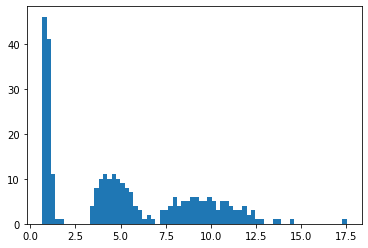

In [99]:
from scipy.stats.distributions import t as tstudent
X=tstudent.rvs(3,size=(N,n), scale=1/np.sqrt(6))+1j*tstudent.rvs(3,size=(N,n), scale=1/np.sqrt(6))
wt=random_spectrum(X)

## Graphe de $x(\tilde{t})$

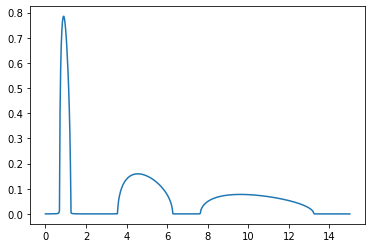

In [7]:
def t_ker(t,u,z,c=0.06):
    """Kernel for fix point algorithm
    Arguments:
    t: current estimate
    u: specter of L^R_\inf
    z: complex argument
    """
    res=1/(-z*(1+u*c*t)+(1-c)*u)
    return res.mean()

def  fix_point(xs,u,
              img_eps=1e-3,cvg_eps=1e-6):
    fs=np.zeros_like(xs)
    t=0
    for i,x in enumerate(xs):
        z=x+1j*img_eps
        err=10*cvg_eps
        
        ##fp iteration
        
        while err>cvg_eps:
            tnew=t_ker(t,u,z)
            err=abs(tnew-t)
            t=tnew
        fs[i]=1/np.pi*t.imag
    
    return fs

L_R=np.array([1,5,10])
xs=np.linspace(0,15,500)
fs=fix_point(xs,L_R)
plt.plot(xs,fs)
        
            
    


    

- Changing paramaters $c$ and $c_i$ can change the overall size of the bulk and relative size of each connected component, respectively

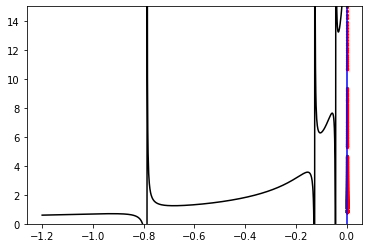

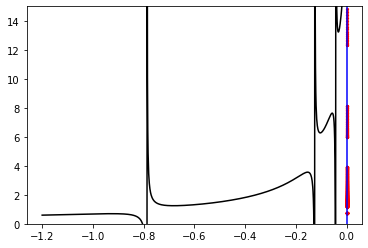

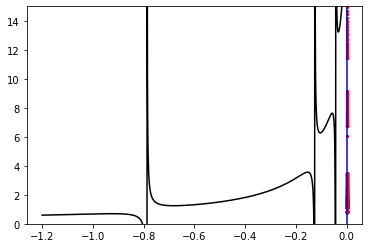

In [101]:
##tracing x(t)

def x_t(t,u,c=0.15,p=None):
    if p is None: p=np.ones(len(u))/len(u)
    return -1/t+c*((p*u)[None,:]/(t[:,None]*u[None,:]+1)).mean(axis=1)
def plot_xt(c=0.06,p=None):
    t=np.linspace(-1.2,-0.0,1000,endpoint=False)
    xs=x_t(t,L_R,c,p)
    plt.ylim([0,15])
    plt.plot(t,x,c='k')
    bins,truth=np.linspace(0,20,1000),np.zeros(1000,dtype=np.bool)


    plt.vlines(0,0,15,color='b')
    cresc_x=np.array([xs[i] for i in range(len(xs)-1) if xs[i+1]>xs[i]])
    cx=cresc_x[np.logical_and(cresc_x>0,cresc_x<15)]
    plt.scatter(np.zeros(len(cx)),cx,c='r',alpha=1.0,s=5)
    plt.show()

plot_xt(c=0.01)
plot_xt(c=0.1)
plot_xt(c=0.1,p=np.array([0.1,0.8,0.1]))

#plt.vlines()

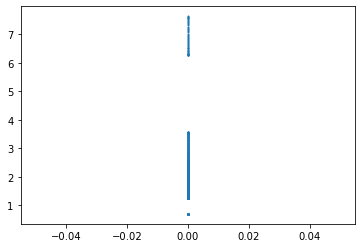

In [81]:
idxs=np.digitize(xs,bins)
truth[idxs-1]=True
aux=[(bins[i],bins[i+1]) for i in range(len(bins)-1) if not truth[i] ]
t0,t1=aux[0][0],aux[0][1]
lims=[]
for y1,y2 in aux[1:]:
    if y1!=t1:
        lims.append((t0,t1))
        t0=y1
    t1=y2
lims.append((t0,t1))

In [ ]:
idxs=np.digitize(xs,bins)
truth[idxs-1]=True
aux=[(bins[i],bins[i+1]) for i in range(len(bins)-1) if not truth[i] ]
t0,t1=aux[0][0],aux[0][1]
lims=[]
for y1,y2 in aux[1:]:
    if y1!=t1:
        lims.append((t0,t1))
        t0=y1
    t1=y2
lims.append((t0,t1))